https://jacobgil.github.io/pytorch-gradcam-book/Class%20Activation%20Maps%20for%20Semantic%20Segmentation.html

In [2]:
# load model

import glob
import os
import cv2
import torch
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
from timm import create_model
import torch.nn.functional as F
from skimage import io, transform
import matplotlib.pyplot as plt
#from models import Unet
from models_3layers import Unet

# Paths
#video_path = "cam1_G7c1_1_10seconds.avi"
#output_video_path = "output_video_with_keypoints_224x224.mp4"

#model_path = "best_model_moreaug_nhid8.pt"
model_path = "best_model_20240109_3layers.pt"

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model loading function
def load_model(model_path, num_output_classes=24):
    model = Unet()
    #model = create_model("vit_base_patch16_224", pretrained=False, in_chans=1, num_classes=num_output_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

# Load model
try:
    model = load_model(model_path)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

#!pip install torchcam


from torchcam.methods import GradCAM
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms.functional as TF

# Initialize Grad-CAM
gradcam = GradCAM(model, target_layer="uEnc3.enc2")



from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, TensorDataset

class FaceMapDataset(Dataset):
    def __init__(
        self,
        data_file="dolensek_facemap_softlabels_224.pt",
        transform=None,
        rotation_degrees=15,
        blur_radius=(1, 2),  # Tuple for Gaussian blur radius range
    ):
        super().__init__()
        self.transform = transform
        self.rotation_degrees = rotation_degrees
        self.blur_radius = blur_radius
        self.data, _, self.targets = torch.load(data_file)

    def __len__(self):
        # Return the total count, multiplied by 5 for five versions per image
        return len(self.targets) * 5

    def __getitem__(self, index):
        # Get the base index (original image index) and augmentation type
        base_index = index // 5  # Original image index
        aug_type = (
            index % 5
        )  # 0: original, 1: flipped, 2: rotated, 3: zoomed, 4: blurred

        # Load the original image and label
        image, label = self.data[base_index].clone(), self.targets[base_index].clone()

        # Apply the augmentation based on the `aug_type`
        #if self.transform is not None:
        if self.transform:
            if aug_type == 1:  # Flipping
                image = image.flip([2])
                label = label.flip([2])
            elif aug_type == 2:  # Rotation
                angle = (torch.rand(1).item() * 2 - 1) * self.rotation_degrees
                image = TF.rotate(image, angle)
                label = TF.rotate(label, angle)
            elif aug_type == 3:  # Zooming
                scale_factor = 1.1 if torch.rand(1).item() < 0.5 else 0.9
                image = self.zoom(image, scale_factor)
                label = self.zoom(label, scale_factor)
            elif aug_type == 4:  # Gaussian Blur
                # Random radius within the specified range
                radius = (
                    torch.rand(1).item() * (self.blur_radius[1] - self.blur_radius[0])
                    + self.blur_radius[0]
                )
                image = TF.gaussian_blur(image, kernel_size=int(radius))
                label = TF.gaussian_blur(label, kernel_size=int(radius))

        return image, label

    def zoom(self, img, scale_factor):
        # Calculate new dimensions
        _, h, w = img.shape
        new_h, new_w = int(h * scale_factor), int(w * scale_factor)

        # Resize and center-crop back to the original size
        img = TF.resize(img, [new_h, new_w])
        img = TF.center_crop(img, [h, w])
        return img


### Make dataset
dataset = FaceMapDataset(transform="test")

x = dataset[0][0]
dim = x.shape[-1]
print("Using %d size of images" % dim)
N = len(dataset)
#train_sampler = SubsetRandomSampler(np.arange(int(0.6 * N)))
#valid_sampler = SubsetRandomSampler(np.arange(int(0.6 * N), int(0.8 * N)))
#test_sampler = SubsetRandomSampler(np.arange(int(0.8 * N), N))

#try randomization
indices = np.random.permutation(N)
train_indices = indices[:int(0.6*N)]
valid_indices = indices[int(0.6*N):int(0.8*N)]
test_indices = indices[int(0.8*N):]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)


batch_size = 4
# Initialize loss and metrics
loss_fun = torch.nn.MSELoss(reduction="sum")

# Initiliaze input dimensions
num_train = len(train_sampler)
num_valid = len(valid_sampler)
num_test = len(test_sampler)
print(
    "Num. train = %d, Num. val = %d, Num. test = %d" % (num_train, num_valid, num_test)
)

# Initialize dataloaders
loader_train = DataLoader(
    dataset=dataset,
    drop_last=False,
    num_workers=0,
    batch_size=batch_size,
    pin_memory=True,
    sampler=train_sampler,
)
loader_valid = DataLoader(
    dataset=dataset,
    drop_last=True,
    num_workers=0,
    batch_size=batch_size,
    pin_memory=True,
    sampler=valid_sampler,
)
loader_test = DataLoader(
    dataset=dataset,
    drop_last=True,
    num_workers=0,
    batch_size=1,
    pin_memory=True,
    sampler=test_sampler,
)


Model loaded successfully.
Using 224 size of images
Num. train = 861, Num. val = 287, Num. test = 287


In [3]:
print(model)

Unet(
  (uEnc11): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (uEnc12): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (uEnc2): convBlock(
    (enc1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (scale): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (act): ReLU()
  )
  (uEnc3): convBlock(
    (enc1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (scale): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (act): ReLU()
  )
  (dec3): convBlock(
    (enc1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (enc2): Conv2d(16, 16, kernel_size=(3, 3), 

In [4]:
# Perform forward pass with Grad-CAM
for i, (inputs, labels) in enumerate(loader_test):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    preds, _ = model(inputs)  # preds shape: [B, 1, H, W]

In [5]:
print(inputs.shape)


torch.Size([1, 1, 224, 224])


OUR MODEL GRADCAM - I'll try it out

In [6]:
class SegmentationModelOutputWrapper(torch.nn.Module):
    def __init__(self, model): 
        super(SegmentationModelOutputWrapper, self).__init__()
        self.model = model
        
    def forward(self, x):
        xHat, _ = self.model(x)  # Unpack the tuple and return only xHat
        return xHat


In [7]:

model = SegmentationModelOutputWrapper(model)
output = model(inputs)

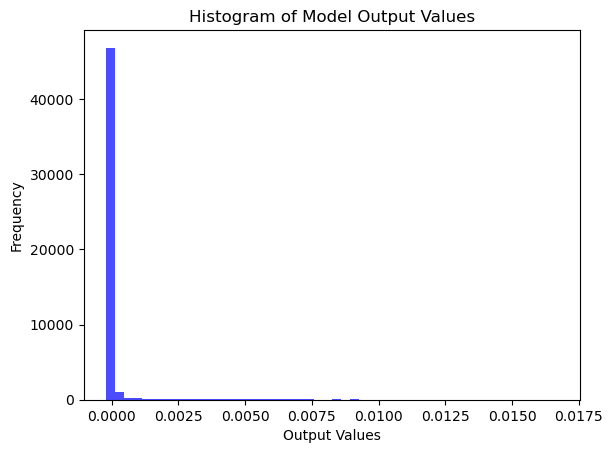

In [8]:
import matplotlib.pyplot as plt

# Get the model output
output = model(inputs)


# Flatten the output tensor
output_flat = output.detach().cpu().numpy().flatten()

# Plot the histogram
plt.hist(output_flat, bins=50, color="blue", alpha=0.7)  # Adjust bins as needed
plt.title("Histogram of Model Output Values")
plt.xlabel("Output Values")
plt.ylabel("Frequency")
plt.show()


tensor([[[[-1.8289e-05,  4.9757e-03,  1.1009e-03,  ...,  1.1009e-03,
            6.9653e-03,  8.1342e-03],
          [-3.7994e-04,  3.4222e-03,  1.1009e-03,  ...,  1.1009e-03,
            7.4613e-03,  1.1961e-02],
          [-1.1467e-03,  4.9057e-03,  1.1009e-03,  ...,  2.6024e-03,
            1.7175e-03,  3.8365e-03],
          ...,
          [ 3.3665e-03,  9.3493e-03,  1.1289e-03,  ...,  1.7302e-03,
           -6.3628e-04,  1.1009e-03],
          [ 9.4966e-03,  2.2137e-02,  2.7026e-03,  ...,  2.1048e-03,
            2.9154e-03,  1.1009e-03],
          [ 1.1081e-03, -5.6171e-03,  1.3120e-03,  ...,  9.2593e-04,
            1.9052e-03,  1.1009e-03]]]], grad_fn=<DivBackward0>)


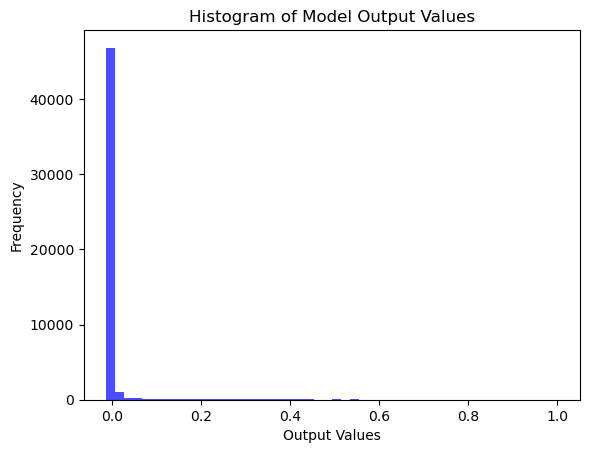

In [9]:
#1. Normalize the Output

normalized_output = output / output.max()  # Normalize to [0, 1]

print(normalized_output)

# Flatten the output tensor
output_flat = normalized_output.detach().cpu().numpy().flatten()

import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(output_flat, bins=50, color="blue", alpha=0.7)  # Adjust bins as needed
plt.title("Histogram of Model Output Values")
plt.xlabel("Output Values")
plt.ylabel("Frequency")
plt.show()

In [10]:
#2. Apply a Threshold to Create Binary Masks
threshold = 0.5
binary_mask = (normalized_output > threshold).float()  # Binary mask for keypoints

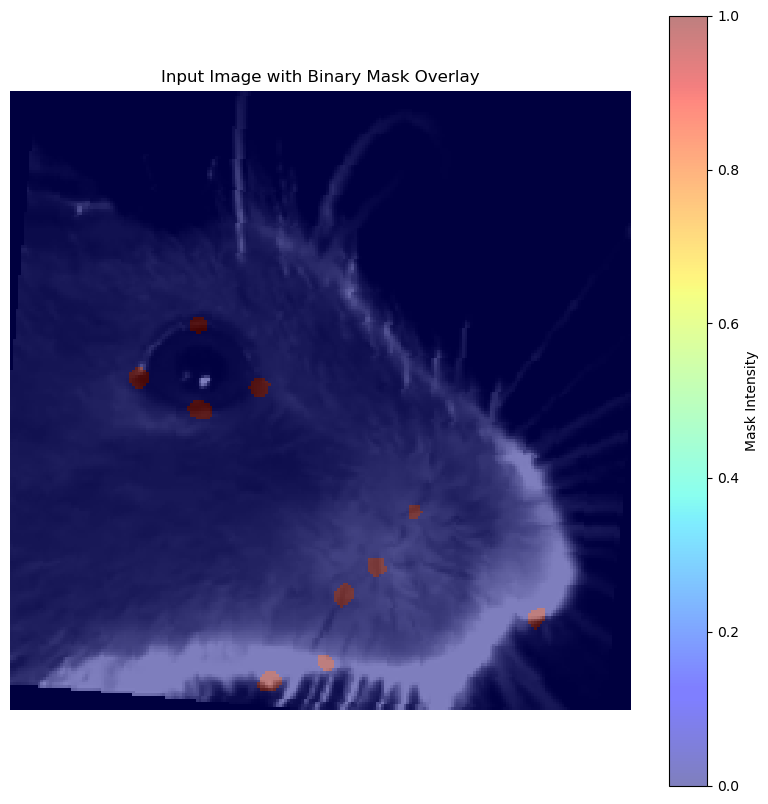

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `inputs` is the original image and `binary_mask` is the mask
input_image = inputs[0, 0].detach().cpu().numpy()  # First image in batch
binary_mask_np = binary_mask[0, 0].detach().cpu().numpy()  # First binary mask

# Plot the input image and overlay the binary mask
plt.figure(figsize=(10, 10))

# Plot the original image
plt.imshow(input_image, cmap="gray", interpolation="nearest")
plt.imshow(binary_mask_np, cmap="jet", alpha=0.5, interpolation="nearest")  # Overlay with transparency
plt.colorbar(label="Mask Intensity")
plt.title("Input Image with Binary Mask Overlay")
plt.axis("off")
plt.show()

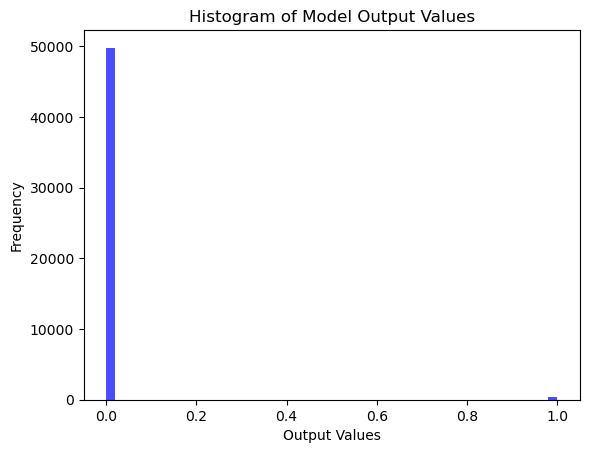

In [12]:
# Flatten the output tensor to check distribution of values. should be purely 0s and 1s
output_flat = binary_mask_np.flatten()

import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(output_flat, bins=50, color="blue", alpha=0.7)  # Adjust bins as needed
plt.title("Histogram of Model Output Values")
plt.xlabel("Output Values")
plt.ylabel("Frequency")
plt.show()

In [13]:
sem_classes = [
    '__background__', 'KP'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}
print(sem_class_to_idx)

{'__background__': 0, 'KP': 1}


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


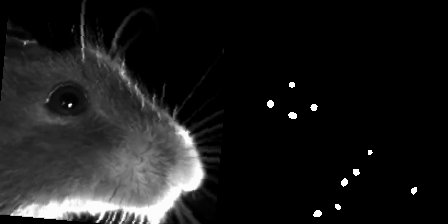

In [14]:
from PIL import Image

category = sem_class_to_idx["KP"]
car_mask = binary_mask_np
mask_uint8 = 255 * np.uint8(car_mask == category)

# Convert input image to uint8
input_image_uint8 = np.uint8(input_image * 255)  # Scale to [0, 255] if input_image is normalized

mask_float = np.float32(car_mask == category)

print(mask_float)
both_images = np.hstack((input_image_uint8, mask_uint8))
Image.fromarray(both_images)


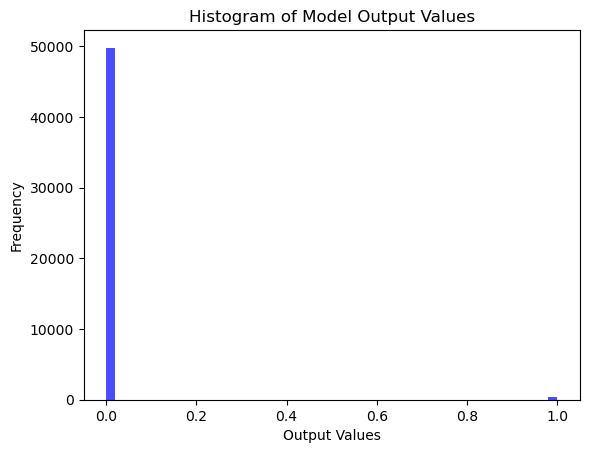

In [15]:
output_flat = mask_float.flatten()

import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(output_flat, bins=50, color="blue", alpha=0.7)  # Adjust bins as needed
plt.title("Histogram of Model Output Values")
plt.xlabel("Output Values")
plt.ylabel("Frequency")
plt.show()

MASKS DONE; NOW FOR GRADCAM

In [16]:
print(model)

SegmentationModelOutputWrapper(
  (model): Unet(
    (uEnc11): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (uEnc12): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (uEnc2): convBlock(
      (enc1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (scale): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (act): ReLU()
    )
    (uEnc3): convBlock(
      (enc1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (scale): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (act): ReLU()
    )
    (dec3): convBlock(
      (enc1): Conv2d(32, 16, kernel_size=(3, 3),

In [17]:
import torch

# Add batch and channel dimensions
input_tensor = torch.tensor(input_image).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 224, 224]

# Ensure it's in the correct dtype and device (e.g., GPU if available)
input_tensor = input_tensor.float().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print(f"Input tensor shape: {input_tensor.shape}")


Input tensor shape: torch.Size([1, 1, 224, 224])


In [18]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import numpy as np
from PIL import Image

# Define the SemanticSegmentationTarget class for single-channel output
class SemanticSegmentationTarget:
    def __init__(self, mask):
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
        
    def __call__(self, model_output):
        # For single-channel output, directly apply the mask
        return (model_output[0, :, :] * self.mask).sum()

model.eval()

# Set the target layer
target_layers = [model.model.uEnc3.enc2]  # Last layer of the deepest encoder block

# Define the target mask (binary or probabilistic)
targets = [SemanticSegmentationTarget(mask_float)]  # Pass the single-channel mask

# Initialize Grad-CAM
with GradCAM(model=model, target_layers=target_layers) as cam:
    # Generate the Grad-CAM heatmap
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]  # First element in batch

    # Overlay the heatmap on the original image
    rgb_img = input_tensor[0, 0].cpu().numpy()  # Convert input to NumPy (grayscale image)
    rgb_img = np.repeat(rgb_img[:, :, None], 3, axis=-1)  # Convert to RGB
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display the result
Image.fromarray(cam_image).show()


DEBUGGING why no gradient activations when using encoding layer 5 - switched to using encoding layer 3 instead - I think I fiddled with the model specification allowing layer 4+5, but not using hem in gradient computation - disregard this part when gradients work in the above part.

In [19]:
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks for the target layer
layer = model.model.uEnc5.enc2
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)

# Perform a forward and backward pass
output = model(input_tensor)
loss = (output * torch.from_numpy(mask_float).to(output.device)).sum()
loss.backward()

# Print activations and gradients
print(f"Activations shape: {activations[0].shape}")
print(f"Gradients shape: {gradients[0].shape}")


AttributeError: 'Unet' object has no attribute 'uEnc5'

In [ ]:
def forward_hook(module, input, output):
    print(f"Forward hook triggered for {module}")
    activations.append(output)

layer.register_forward_hook(forward_hook)

# Perform a forward pass
output = model(input_tensor)
print(f"Model output shape: {output.shape}")


In [ ]:
def backward_hook(module, grad_input, grad_output):
    print(f"Backward hook triggered for {module}")
    gradients.append(grad_output[0])

layer.register_backward_hook(backward_hook)


In [ ]:
# Create a dummy loss based on activations
loss = activations[0].sum()  # Ensure the loss depends on target layer output
model.zero_grad()
loss.backward()

# Print captured gradients
if gradients:
    print(f"Gradients shape: {gradients[0].shape}")
else:
    print("No gradients captured. Verify the loss computation and hooks.")


In [ ]:
activations = []  # Reset the activations list

def forward_hook(module, input, output):
    print(f"Forward hook triggered for {module}")
    activations.append(output)

# Re-register the forward hook
layer = model.model.uEnc5.enc2
hook_handle = layer.register_forward_hook(forward_hook)

# Perform the forward pass
output = model(input_tensor)
print(f"Model output shape: {output.shape}")

# Remove the hook after the test (optional)
hook_handle.remove()

# Check if activations are captured
if activations:
    print(f"Activations shape: {activations[0].shape}")
else:
    print("No activations captured. Verify if the target layer is being used.")
